# Imports

In [1]:
from github.experiment1.src.process_data import save_maps, load_maps, index2sentence
from github.experiment1.src.dataset import TranslationDataset, AutoencoderDataset, padding_collate_fn, Batch
from github.experiment1.src.encoderdecoder import EncoderDecoder, save_model, load_model
from github.experiment1.src.loss import LabelSmoothing
from github.experiment1.src.optimizer import get_std_opt
from github.experiment1.src.train import train, train_translation_semisupervised, train_translation_semisupervised2
from github.experiment1.src.evaluate import evaluate_translation_two_models, evaluate_translation
import gc

In [3]:
import torch
from torch import nn
import matplotlib
matplotlib.use("module://ipykernel.pylab.backend_inline")
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.insert(0, 'C:\\Users\\scj14\\BYU\\research\\image_encoder\\github\\experiment1')

In [89]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu

# Loading in pre-trained models and datas

## Translation train data (2970 lines)

In [4]:
src_name = "fra_txt-2021-04-13-13-35"
trg_name = "fra_eng-2021-04-13-15-26"

src_word2index, src_index2word = load_maps(src_name, map_dir="outputs/maps/")
src_vocab = [word for word, index in src_word2index.items()]
trg_word2index, trg_index2word = load_maps(trg_name, map_dir="outputs/maps/")
trg_vocab = [word for word, index in trg_word2index.items()]

In [5]:
src_path = "text_corpora/prepared/fra-eng/train/fra_3k.txt"
trg_path = "text_corpora/prepared/fra-eng/train/eng_3k.txt"
trans_dataset = TranslationDataset(src_path, trg_path)
trans_dataset.init_using_existing_maps(
    src_vocab, 
    src_word2index, 
    src_index2word,  
    trg_vocab, 
    trg_word2index, 
    trg_index2word,  
)

Converting lines to indices...


In [71]:
len(trans_dataset)

2970

## Test data (37117 lines)

In [6]:
src_test_path = "text_corpora/prepared/fra-eng/test/fra.txt"
trg_test_path = "text_corpora/prepared/fra-eng/test/eng.txt"
test_dataset = TranslationDataset(src_test_path, trg_test_path)
test_dataset.init_using_existing_maps(
    src_vocab, 
    src_word2index, 
    src_index2word,  
    trg_vocab, 
    trg_word2index, 
    trg_index2word,  
)

Converting lines to indices...


In [72]:
len(test_dataset)

37117

## Pre-trained language models

In [16]:
src_model = load_model(src_name, model_dir="outputs/models/")
trg_model = load_model(trg_name, model_dir="outputs/models/")
src_model = src_model.eval()
trg_model = trg_model.eval()

# Alignment model training and evaluation

## Encoding the data to vector space

In [9]:
batch = Batch([trans_dataset[i] for i in range(len(trans_dataset))])

In [10]:
src_h = src_model.encode(batch.src.cpu())
src_h = src_h.detach()
trg_h = trg_model.encode(batch.trg.cpu())
trg_h = trg_h.detach()
src_h.shape, trg_h.shape

(torch.Size([2970, 256]), torch.Size([2970, 256]))

### Visualization of the first 60 dimensions for 100 data points

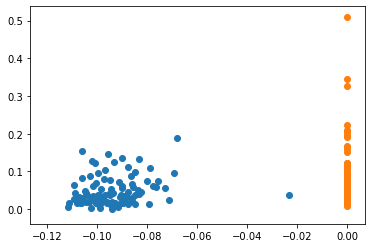

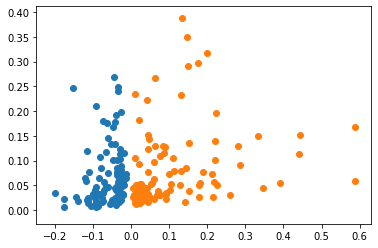

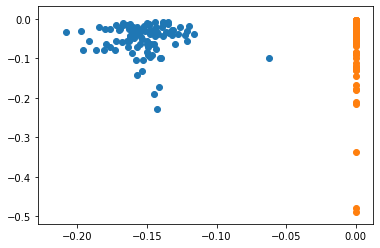

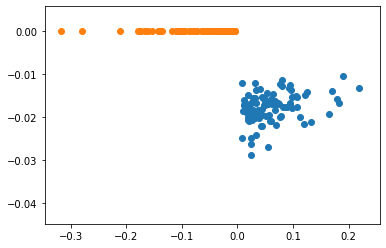

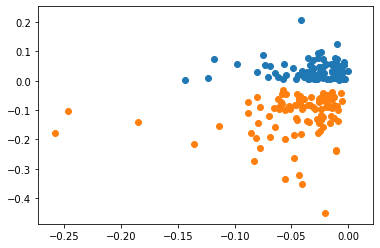

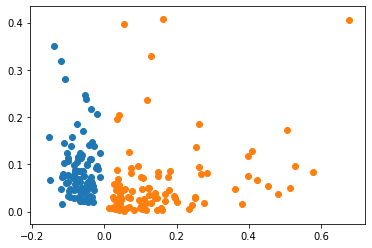

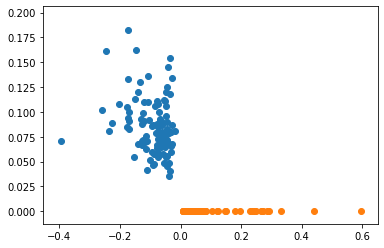

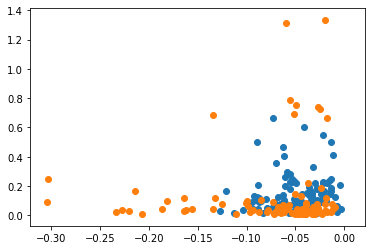

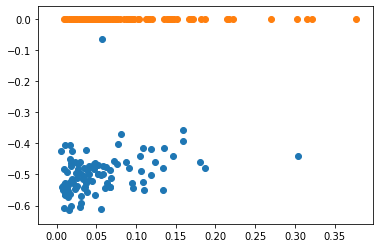

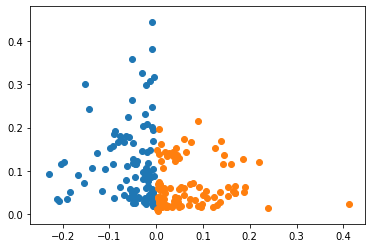

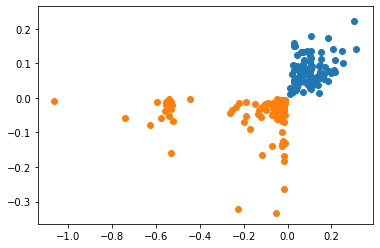

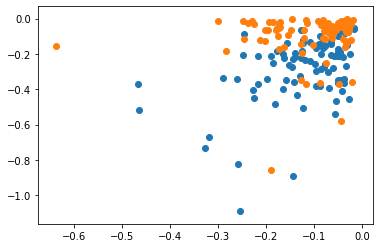

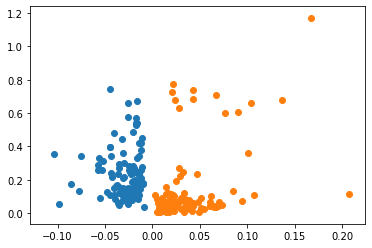

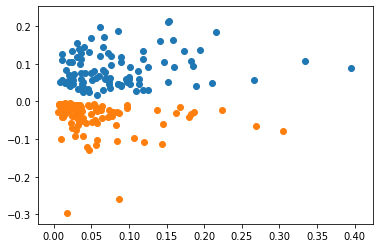

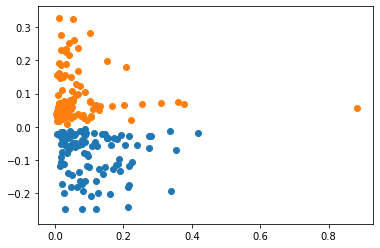

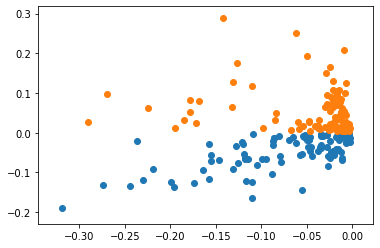

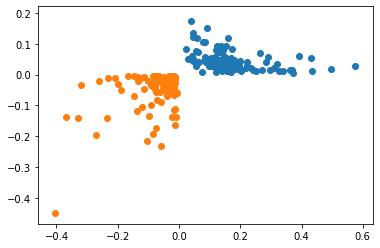

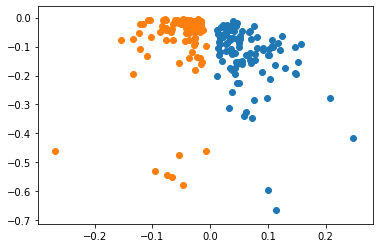

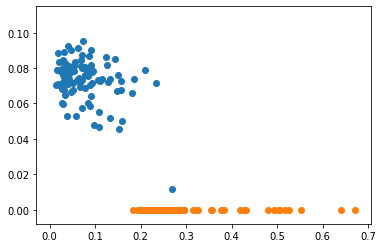

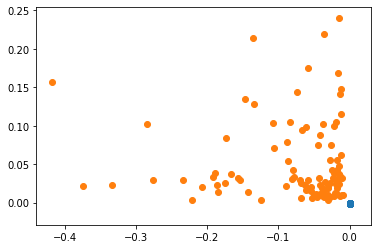

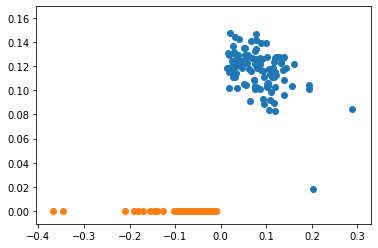

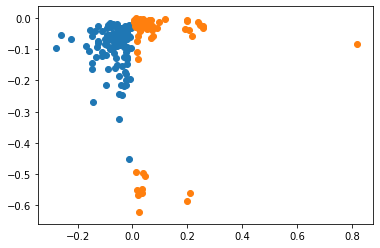

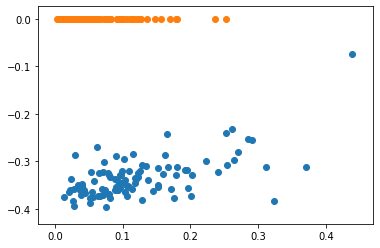

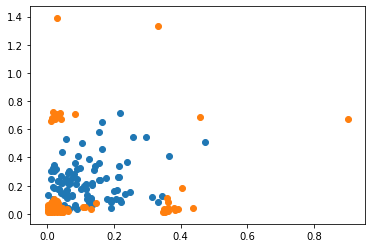

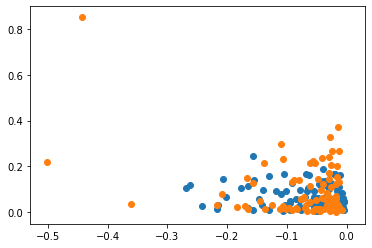

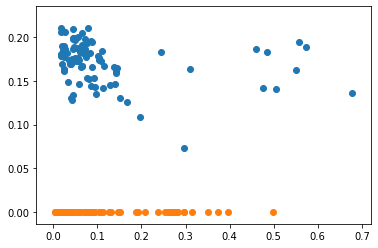

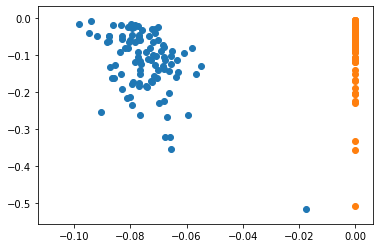

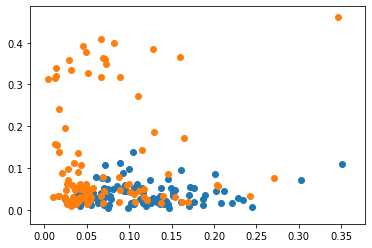

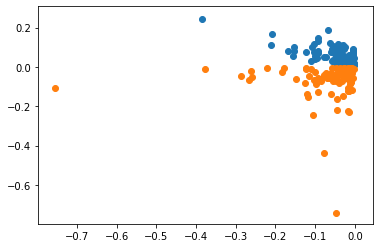

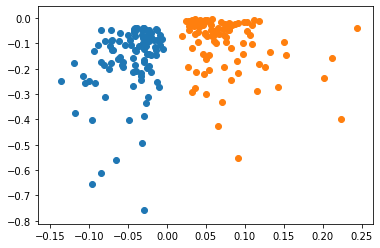

In [17]:
for i in range(30):
    plt.scatter(trg_h.cpu()[:100,0+2*i], trg_h.cpu()[:100,1+2*i])
    plt.scatter(src_h.cpu()[:100,0+2*i], src_h.cpu()[:100,1+2*i])
    plt.show()

## Linear model training

In [20]:
linear_model = nn.Linear(256, 256)
criterion = nn.L1Loss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=1)

In [21]:
cuda = torch.device("cuda")
linear_model = linear_model.to(cuda)
src_h = src_h.to(cuda)
trg_h = trg_h.to(cuda)

In [22]:
for i in range(50000):
    y_hat = linear_model(src_h)
    loss = criterion(y_hat, trg_h)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i % 1000 == 0:
        print("i: {}, loss: {:.10f}".format(i, loss))

i: 0, loss: 0.1523001939
i: 1000, loss: 0.0456128605
i: 2000, loss: 0.0423809178
i: 3000, loss: 0.0409556292
i: 4000, loss: 0.0401649885
i: 5000, loss: 0.0396543331
i: 6000, loss: 0.0392778665
i: 7000, loss: 0.0389863737
i: 8000, loss: 0.0387532637
i: 9000, loss: 0.0385623239
i: 10000, loss: 0.0384031162
i: 11000, loss: 0.0382661186
i: 12000, loss: 0.0381513797
i: 13000, loss: 0.0380498283
i: 14000, loss: 0.0379585885
i: 15000, loss: 0.0378797837
i: 16000, loss: 0.0378078707
i: 17000, loss: 0.0377424620
i: 18000, loss: 0.0376830325
i: 19000, loss: 0.0376297832
i: 20000, loss: 0.0375804007
i: 21000, loss: 0.0375343747
i: 22000, loss: 0.0374952890
i: 23000, loss: 0.0374561809
i: 24000, loss: 0.0374211930
i: 25000, loss: 0.0373896658
i: 26000, loss: 0.0373600014
i: 27000, loss: 0.0373279862
i: 28000, loss: 0.0373016745
i: 29000, loss: 0.0372781791
i: 30000, loss: 0.0372537151
i: 31000, loss: 0.0372307971
i: 32000, loss: 0.0372073688
i: 33000, loss: 0.0371888205
i: 34000, loss: 0.037170112

In [29]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=10)
for i in range(100000):
    y_hat = linear_model(src_h)
    loss = criterion(y_hat, trg_h)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i % 1000 == 0:
        print("i: {}, loss: {:.10f}".format(i, loss))

i: 0, loss: 0.0053946925
i: 1000, loss: 0.0051623257
i: 2000, loss: 0.0051321015
i: 3000, loss: 0.0051124878
i: 4000, loss: 0.0050980686
i: 5000, loss: 0.0050868164
i: 6000, loss: 0.0050777020
i: 7000, loss: 0.0050701243
i: 8000, loss: 0.0050636996
i: 9000, loss: 0.0050581703
i: 10000, loss: 0.0050533544
i: 11000, loss: 0.0050491169
i: 12000, loss: 0.0050453576
i: 13000, loss: 0.0050419983
i: 14000, loss: 0.0050389781
i: 15000, loss: 0.0050362479
i: 16000, loss: 0.0050337682
i: 17000, loss: 0.0050315070
i: 18000, loss: 0.0050294371
i: 19000, loss: 0.0050275349
i: 20000, loss: 0.0050257826
i: 21000, loss: 0.0050241635
i: 22000, loss: 0.0050226636
i: 23000, loss: 0.0050212708
i: 24000, loss: 0.0050199744
i: 25000, loss: 0.0050187656
i: 26000, loss: 0.0050176368
i: 27000, loss: 0.0050165798
i: 28000, loss: 0.0050155893
i: 29000, loss: 0.0050146594
i: 30000, loss: 0.0050137849
i: 31000, loss: 0.0050129620
i: 32000, loss: 0.0050121858
i: 33000, loss: 0.0050114538
i: 34000, loss: 0.005010761

### Visualization after transformation

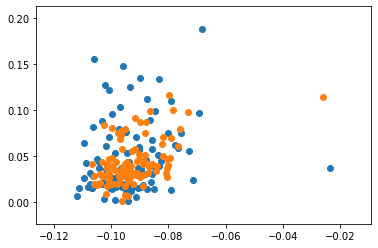

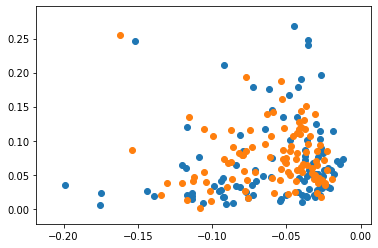

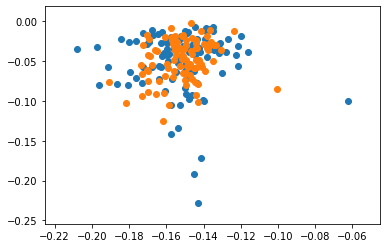

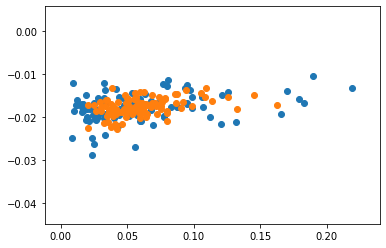

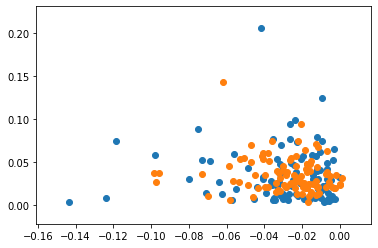

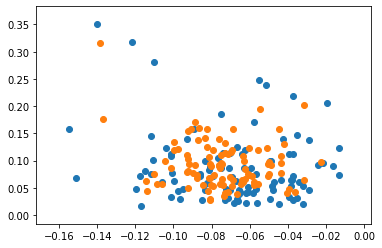

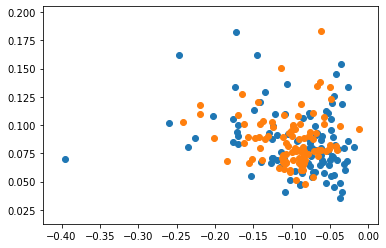

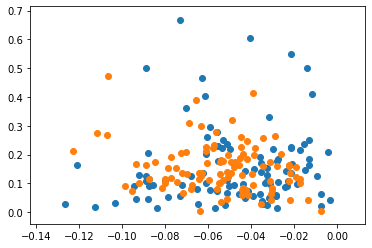

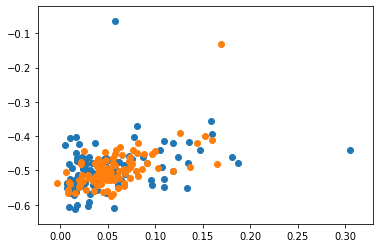

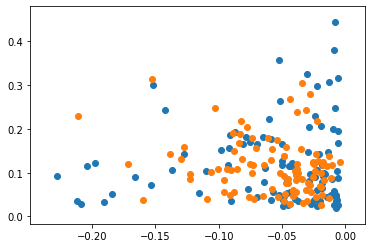

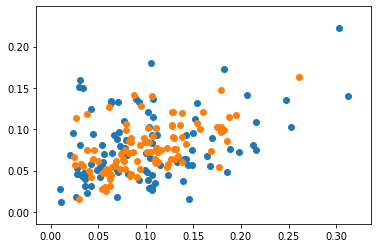

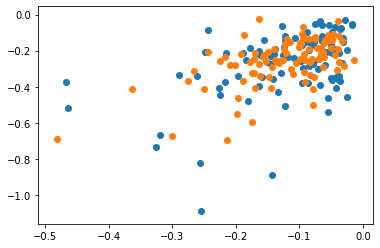

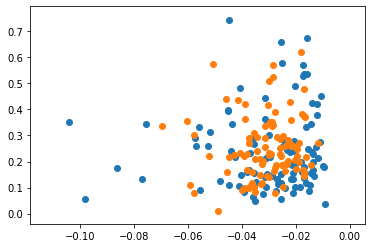

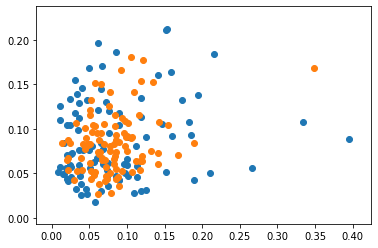

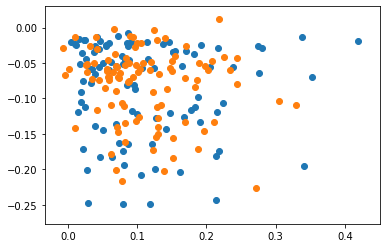

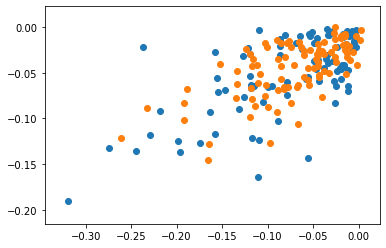

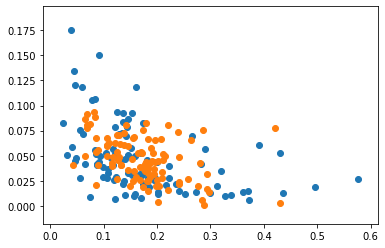

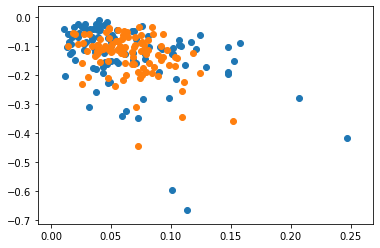

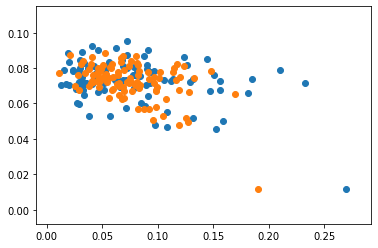

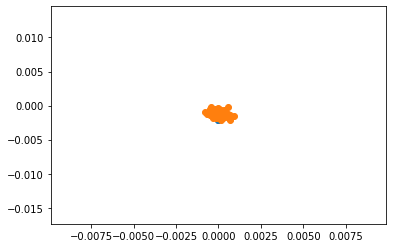

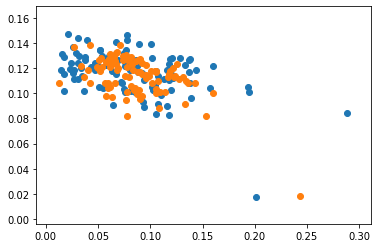

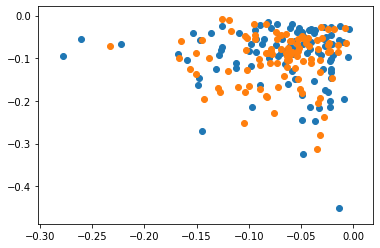

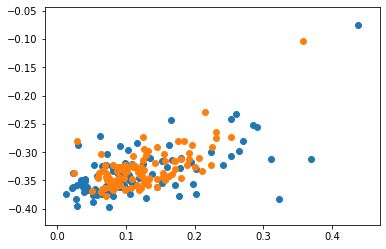

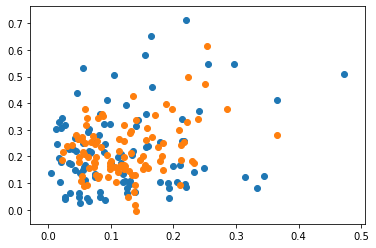

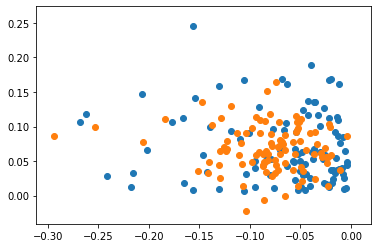

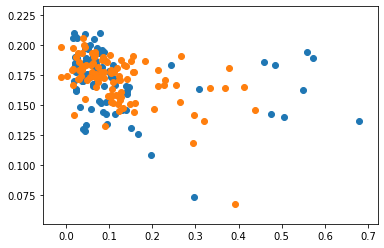

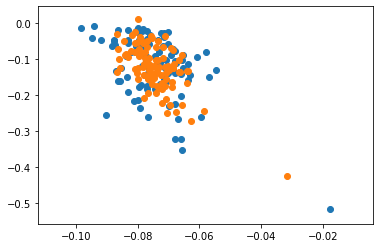

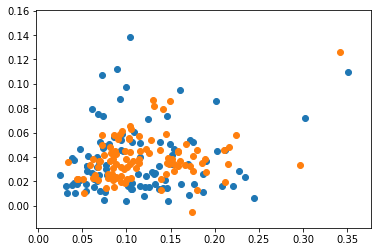

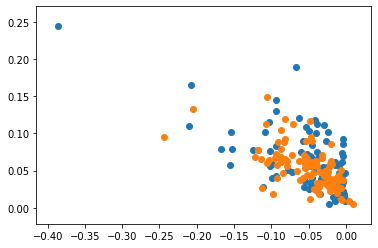

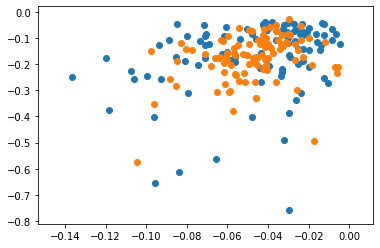

In [30]:
y_hat = linear_model(src_h)
for i in range(30):
    plt.scatter(trg_h[:100,0+2*i].cpu(), trg_h[:100,1+2*i].cpu())
    plt.scatter(y_hat[:100,0+2*i].detach().cpu(), y_hat[:100,1+2*i].detach().cpu())
    plt.show()

## Evaluation of the linear model

### 100 example pairs for the train data

In [31]:
inp_src = batch.src[0]
for i in range(len(trans_dataset)):
    target = trans_dataset[i][1]
    target = index2sentence(target, trg_index2word)
    memory = trg_model.extract_features(y_hat[i].unsqueeze(0))
    decoded = trg_model.greedy_decode_from_memory(inp_src, memory[0])
    output = index2sentence(decoded[1:].tolist(), trg_index2word)
    print("Target:", target)
    print("Output:", output)
    print()
    if i > 100: break

Target: are we just friends ?
Output: did you be interested on television ? EOS

Target: you should try to write more .
Output: you should try to save more quickly than money . EOS

Target: that s what i wanted .
Output: i know it s somewhere . EOS

Target: you should buy yourself a new knife .
Output: you should save a safe place to paint . EOS

Target: no one s in sight .
Output: tom is out of losing the situation . EOS

Target: you re very rude .
Output: you re awfully threatened . EOS

Target: can you help me with the washing up ?
Output: can you forget to share me here ? EOS

Target: i m sorry if i scared you .
Output: i m wondering if you were do it . EOS

Target: were you at home all morning ?
Output: did you go anywhere at christmas is here ? EOS

Target: why didn t you just leave ?
Output: why won t you guys try that kiss ? EOS

Target: i ll help you as much as i can .
Output: i ll help you if i speak it . EOS

Target: this is .
Output: you are lots from she . EOS

Target: i m

### 100 example pairs for the test data

In [33]:
for i in range(len(test_dataset)):
    target = test_dataset[i][1]
    target = index2sentence(target, trg_index2word)
    
    batch = Batch([test_dataset[i]])
    encoded = src_model.encode(batch.src)
    transformed = linear_model(encoded)
    memory = trg_model.extract_features(transformed)
    decoded = trg_model.greedy_decode_from_memory(inp_src, memory[0])
    output = index2sentence(decoded[1:-1].tolist(), trg_index2word)
    print("Target:", target)
    print("Output:", output)
    print()
    if i > 100: break

Target: they live on the floor below .
Output: we took people in the theater every year .

Target: i m surprised to see you .
Output: i m wondering you will die now .

Target: don t be afraid to make mistakes when speaking english .
Output: we cannot consider doing that in public .

Target: let s try it once more .
Output: we cannot need a car keys .

Target: if you had been a little more patient you could have succeeded .
Output: you might have a talk as an hour as you could do this afternoon .

Target: i m looking forward to christmas .
Output: i was advised by stay here .

Target: i d prefer to speak to you in private .
Output: i expect you to get hurt by any help .

Target: you were drunk last night weren t you ?
Output: did you meet each other day isn t it ?

Target: we ll never get through this .
Output: we should get a truth .

Target: it s good that i have a daughter .
Output: i know it s a good book from my age .

Target: i didn t know you were awake .
Output: i was hoping you

In [98]:
bleu_scores = []
for i in range(len(test_dataset)):
    target = test_dataset[i][1]
    target = index2sentence(target, trg_index2word)
    
    batch = Batch([test_dataset[i]])
    encoded = src_model.encode(batch.src)
    transformed = linear_model(encoded)
    memory = trg_model.extract_features(transformed)
    decoded = trg_model.greedy_decode_from_memory(inp_src, memory[0])
    output = index2sentence(decoded[1:-1].tolist(), trg_index2word)
    
    bleu = sentence_bleu([target.split()], output.split(), weights=[0.5, 0.5])
    bleu_scores.append(bleu)
    if i > 1000: break

In [99]:
np.mean(bleu_scores)

0.07775879085033921

## Neural model training (3 layer linear network with ReLU activation)

In [34]:
neural_model = nn.Sequential(
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 256)
)
neural_model = neural_model.cuda()
criterion = nn.L1Loss()
optimizer = torch.optim.SGD(neural_model.parameters(), lr=1)

In [35]:
for i in range(30000):
    y_hat = neural_model(src_h)
    loss = criterion(y_hat, trg_h)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i % 1000 == 0:
        print("i: {}, loss: {:.10f}".format(i, loss))

i: 0, loss: 0.1408787668
i: 1000, loss: 0.0458474718
i: 2000, loss: 0.0430966206
i: 3000, loss: 0.0413390324
i: 4000, loss: 0.0403231569
i: 5000, loss: 0.0396328233
i: 6000, loss: 0.0389978774
i: 7000, loss: 0.0385219827
i: 8000, loss: 0.0379765816
i: 9000, loss: 0.0375149883
i: 10000, loss: 0.0370631441
i: 11000, loss: 0.0365935899
i: 12000, loss: 0.0363620631
i: 13000, loss: 0.0357853919
i: 14000, loss: 0.0359290689
i: 15000, loss: 0.0349676386
i: 16000, loss: 0.0348593593
i: 17000, loss: 0.0347710662
i: 18000, loss: 0.0335824415
i: 19000, loss: 0.0332856812
i: 20000, loss: 0.0329073668
i: 21000, loss: 0.0330416076
i: 22000, loss: 0.0322856605
i: 23000, loss: 0.0319526568
i: 24000, loss: 0.0316319317
i: 25000, loss: 0.0317521058
i: 26000, loss: 0.0310544968
i: 27000, loss: 0.0305794999
i: 28000, loss: 0.0303968322
i: 29000, loss: 0.0301746968


In [36]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(neural_model.parameters(), lr=10)
for i in range(100000):
    y_hat = neural_model(src_h)
    loss = criterion(y_hat, trg_h)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i % 1000 == 0:
        print("i: {}, loss: {:.10f}".format(i, loss))

i: 0, loss: 0.0035389001
i: 1000, loss: 0.0034431019
i: 2000, loss: 0.0032274437
i: 3000, loss: 0.0032000171
i: 4000, loss: 0.0027582676
i: 5000, loss: 0.0028389767
i: 6000, loss: 0.0024410586
i: 7000, loss: 0.0022361523
i: 8000, loss: 0.0020075392
i: 9000, loss: 0.0020443136
i: 10000, loss: 0.0018938818
i: 11000, loss: 0.0019338797
i: 12000, loss: 0.0017110457
i: 13000, loss: 0.0016180015
i: 14000, loss: 0.0015766266
i: 15000, loss: 0.0015852174
i: 16000, loss: 0.0013982782
i: 17000, loss: 0.0013356297
i: 18000, loss: 0.0013678306
i: 19000, loss: 0.0012674454
i: 20000, loss: 0.0012757540
i: 21000, loss: 0.0011356608
i: 22000, loss: 0.0011516203
i: 23000, loss: 0.0011135512
i: 24000, loss: 0.0011108486
i: 25000, loss: 0.0012325902
i: 26000, loss: 0.0009633278
i: 27000, loss: 0.0009902144
i: 28000, loss: 0.0009685856
i: 29000, loss: 0.0009528792
i: 30000, loss: 0.0008928390
i: 31000, loss: 0.0009039012
i: 32000, loss: 0.0009039897
i: 33000, loss: 0.0008349742
i: 34000, loss: 0.000830165

In [37]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(neural_model.parameters(), lr=1)
for i in range(100000):
    y_hat = neural_model(src_h)
    loss = criterion(y_hat, trg_h)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i % 1000 == 0:
        print("i: {}, loss: {:.10f}".format(i, loss))

i: 0, loss: 0.0003388834
i: 1000, loss: 0.0003023467
i: 2000, loss: 0.0003019717
i: 3000, loss: 0.0003016530
i: 4000, loss: 0.0003013586
i: 5000, loss: 0.0003010779
i: 6000, loss: 0.0003008065
i: 7000, loss: 0.0003005420
i: 8000, loss: 0.0003002831
i: 9000, loss: 0.0003000284
i: 10000, loss: 0.0002997773
i: 11000, loss: 0.0002995294
i: 12000, loss: 0.0002992841
i: 13000, loss: 0.0002990411
i: 14000, loss: 0.0002988004
i: 15000, loss: 0.0002985617
i: 16000, loss: 0.0002983250
i: 17000, loss: 0.0002980900
i: 18000, loss: 0.0002978566
i: 19000, loss: 0.0002976249
i: 20000, loss: 0.0002973946
i: 21000, loss: 0.0002971658
i: 22000, loss: 0.0002969381
i: 23000, loss: 0.0002967117
i: 24000, loss: 0.0002964864
i: 25000, loss: 0.0002962621
i: 26000, loss: 0.0002960389
i: 27000, loss: 0.0002958164
i: 28000, loss: 0.0002955948
i: 29000, loss: 0.0002953744
i: 30000, loss: 0.0002951548
i: 31000, loss: 0.0002949362
i: 32000, loss: 0.0002947185
i: 33000, loss: 0.0002945015
i: 34000, loss: 0.000294285

In [66]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(neural_model.parameters(), lr=10)
for i in range(10000):
    y_hat = neural_model(src_h)
    loss = criterion(y_hat, trg_h)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i % 1000 == 0:
        print("i: {}, loss: {:.10f}".format(i, loss))

i: 0, loss: 0.0001498339
i: 1000, loss: 0.0001495144
i: 2000, loss: 0.0001492010
i: 3000, loss: 0.0001488928
i: 4000, loss: 0.0001485851
i: 5000, loss: 0.0001482813
i: 6000, loss: 0.0001479832
i: 7000, loss: 0.0001476817
i: 8000, loss: 0.0001473891
i: 9000, loss: 0.0001470966


### Visualization after transformation

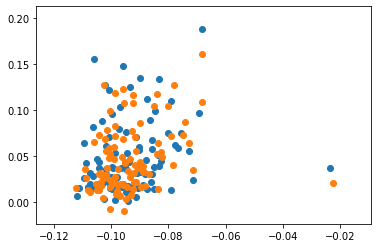

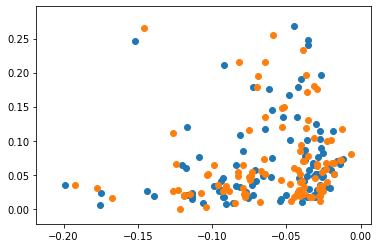

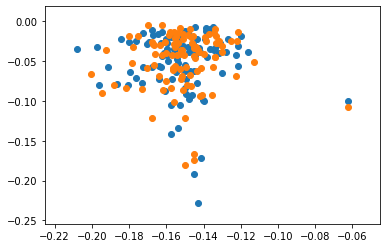

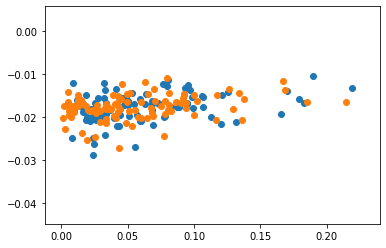

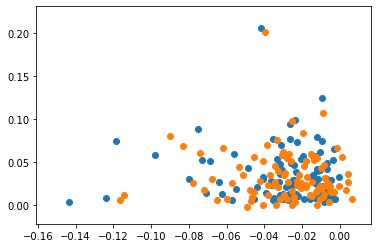

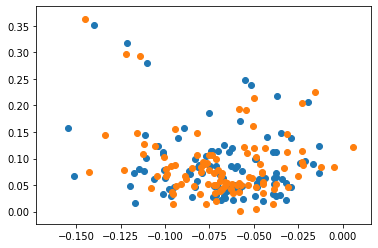

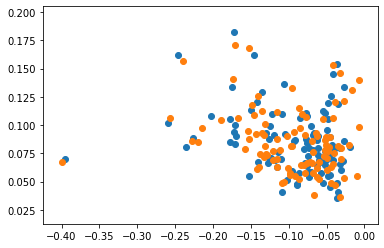

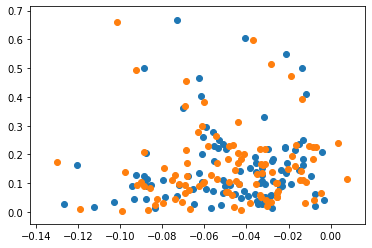

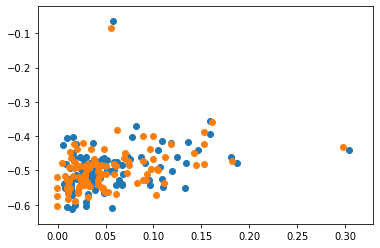

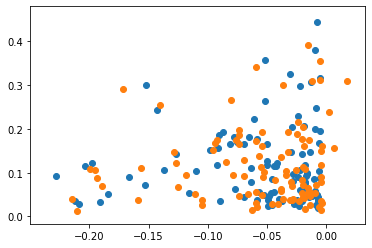

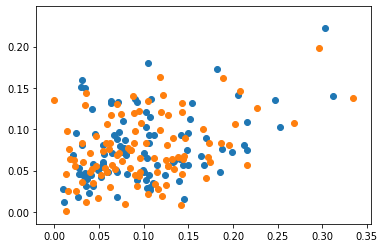

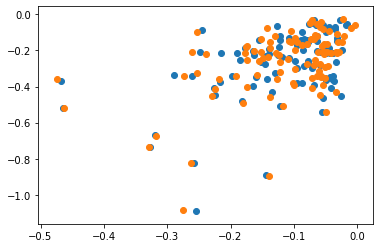

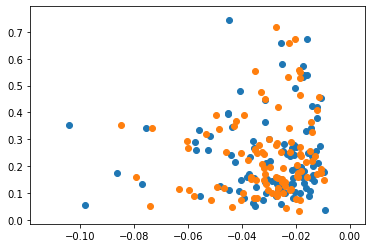

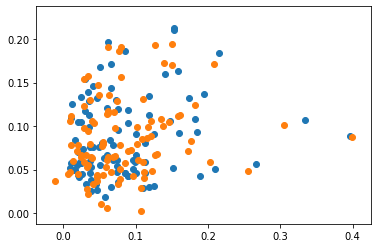

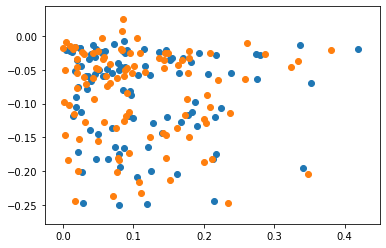

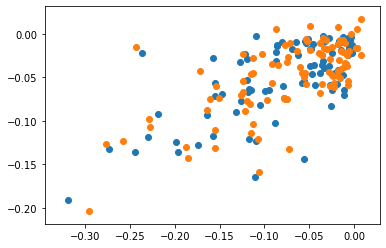

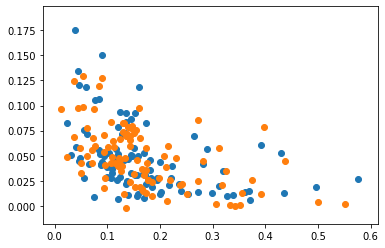

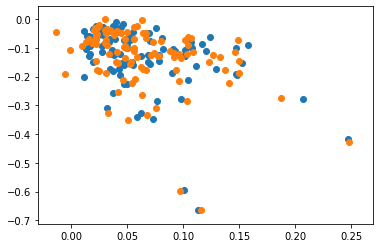

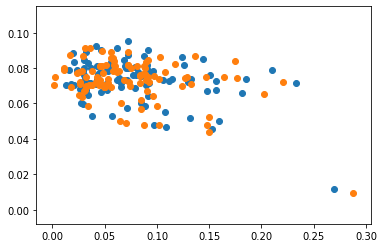

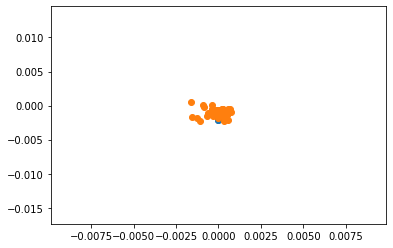

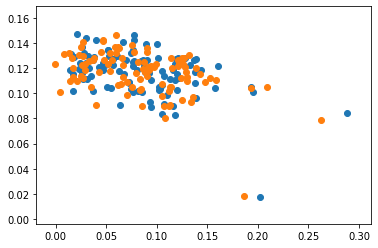

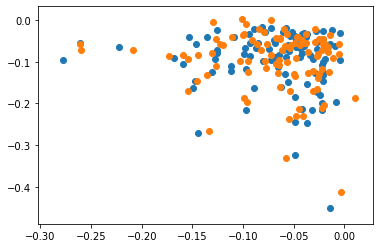

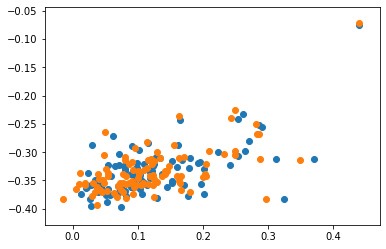

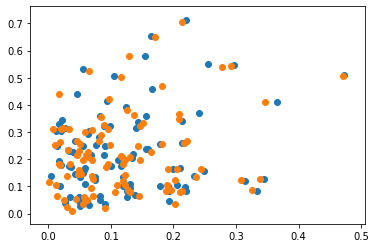

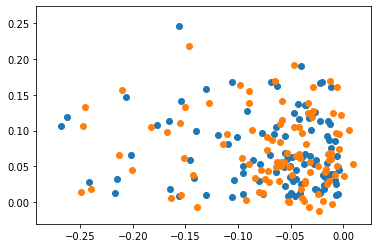

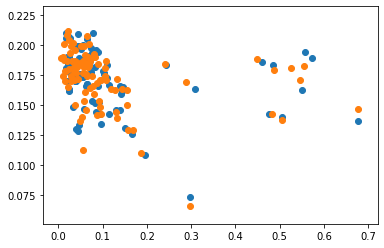

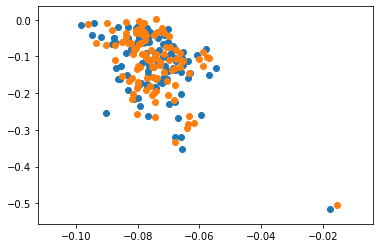

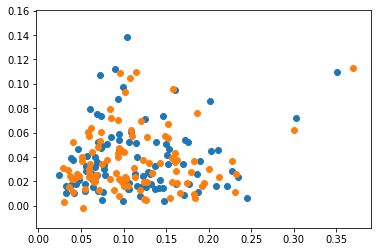

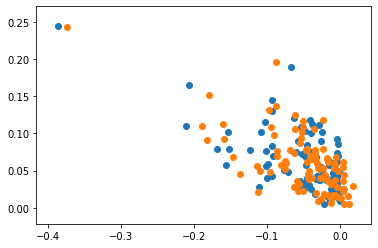

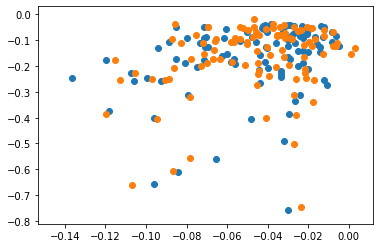

In [67]:
y_hat = neural_model(src_h)
for i in range(30):
    plt.scatter(trg_h[:100,0+2*i].cpu(), trg_h[:100,1+2*i].cpu())
    plt.scatter(y_hat[:100,0+2*i].detach().cpu(), y_hat[:100,1+2*i].detach().cpu())
    plt.show()

## Evaluation of the neural model

### 100 example pairs for the train data

In [97]:
inp_src = batch.src[0]
for i in range(len(trans_dataset)):
    target = trans_dataset[i][1]
    target = index2sentence(target, trg_index2word)
    memory = trg_model.extract_features(y_hat[i].unsqueeze(0))
    decoded = trg_model.greedy_decode_from_memory(inp_src, memory[0])
    output = index2sentence(decoded[1:-1].tolist(), trg_index2word)
    bleu = sentence_bleu([target.split()], output.split(), weights=[0.5, 0.5])
    print("Target:", target)
    print("Output:", output)
    print("BLEU:", bleu)
    print()
    if i > 100: break

Target: are we just friends ?
Output: are we just friends anywhere ?
BLEU: 0.7071067811865476

Target: you should try to write more .
Output: you should try to write more mine .
BLEU: 0.7905694150420949

Target: that s what i wanted .
Output: that s what i wanted .
BLEU: 1.0

Target: you should buy yourself a new knife .
Output: you should buy yourself a new knife .
BLEU: 1.0

Target: no one s in sight .
Output: no one s in sight .
BLEU: 1.0

Target: you re very rude .
Output: you re very rude .
BLEU: 1.0

Target: can you help me with the washing up ?
Output: can you help me with the washing up ?
BLEU: 1.0

Target: i m sorry if i scared you .
Output: i m sorry if i scared you .
BLEU: 1.0

Target: were you at home all morning ?
Output: were you at home all morning ?
BLEU: 1.0

Target: why didn t you just leave ?
Output: why didn t you just leave ?
BLEU: 1.0

Target: i ll help you as much as i can .
Output: i ll help you as much as i can .
BLEU: 1.0

Target: this is .
Output: this is goo

### 100 example pairs for the test data

In [73]:
for i in range(len(test_dataset)):
    target = test_dataset[i][1]
    target = index2sentence(target, trg_index2word)
    
    batch = Batch([test_dataset[i]])
    encoded = src_model.encode(batch.src)
    transformed = neural_model(encoded)
    memory = trg_model.extract_features(transformed)
    decoded = trg_model.greedy_decode_from_memory(inp_src, memory[0])
    output = index2sentence(decoded[1:-1].tolist(), trg_index2word)
    print("Target:", target)
    print("Output:", output)
    print()
    if i > 100: break

Target: they live on the floor below .
Output: they tied the street because they hit a .

Target: i m surprised to see you .
Output: i am trying to see you now .

Target: don t be afraid to make mistakes when speaking english .
Output: i does not go home that japanese as possible .

Target: let s try it once more .
Output: there s getting more quickly .

Target: if you had been a little more patient you could have succeeded .
Output: if you d had been treated you would have changed .

Target: i m looking forward to christmas .
Output: i ll break into that coffee .

Target: i d prefer to speak to you in private .
Output: i d prefer to break with him .

Target: you were drunk last night weren t you ?
Output: did you meet you were absent today ?

Target: we ll never get through this .
Output: we ll never come back you .

Target: it s good that i have a daughter .
Output: this is a book that i know of this article for a very good .

Target: i didn t know you were awake .
Output: you was ev

In [100]:
bleu_scores = []
for i in range(len(test_dataset)):
    target = test_dataset[i][1]
    target = index2sentence(target, trg_index2word)
    
    batch = Batch([test_dataset[i]])
    encoded = src_model.encode(batch.src)
    transformed = neural_model(encoded)
    memory = trg_model.extract_features(transformed)
    decoded = trg_model.greedy_decode_from_memory(inp_src, memory[0])
    output = index2sentence(decoded[1:-1].tolist(), trg_index2word)
    
    bleu = sentence_bleu([target.split()], output.split(), weights=[0.5, 0.5])
    bleu_scores.append(bleu)
    if i > 1000: break

In [101]:
np.mean(bleu_scores)

0.08181225161609619